In [1]:
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import json
import re
import pymorphy2
import numpy as np
from scipy import spatial
import pandas as pd

In [2]:
themes = ["sport", "science", "shopping", "travel"]

In [3]:
def get_world_list_by_theme(theme):
    url_of_key_word = f"https://relatedwords.org/relatedto/{theme}"
    
    result = requests.get(url_of_key_word)
    soup = BeautifulSoup(result.text)
    # get html
    # words stored in <script> json
    html_of_words = soup.find_all('script', {'id': 'preloadedDataEl'})[0]
    # Get list of words from JSON
    word_list = json.loads(re.search(r'>(.+)<', str(html_of_words)).group(1))['terms']
    return set([word['word'] for word in word_list])

Get dictorinary to words by theme

In [4]:
themes_dict = dict()

for theme in themes:
    themes_dict[theme] = get_world_list_by_theme(theme)

Get set of words in article

In [5]:
with open("shoot_the_moon.txt") as f:
    content = f.readlines()

content = [x.strip() for x in content]

words_set = list(set(' '.join(content).lower().split(" ")))
all_text = ' '.join(content).lower().split(" ")

In [6]:
morph = pymorphy2.MorphAnalyzer(lang='uk')

In [7]:
def get_normal_form(list_of_words):
    normal_form = []
    for word in list_of_words:
        p = morph.parse(word)[0]
        normal_form.append(p.normal_form)
    return normal_form

In [8]:
normal_form = get_normal_form(all_text)

In [9]:
def get_vector(common_set, text_set):
    out_vector = np.zeros(len(common_set))

    for i, word in enumerate(common_set):
        for s in text_set:
            if word == s:
                out_vector[i] += 1
    
    return out_vector

In [10]:
cosine_sims = dict()

for theme in themes:
    common_set = list(set(normal_form + list(themes_dict.get(theme))))
    
    theme_vector = get_vector(common_set, list(themes_dict.get(theme)))
    
    text_vector = get_vector(common_set, normal_form)
    
    cosine_sims[theme] = 1 - spatial.distance.cosine(theme_vector, text_vector)
    
cosine_sims

{'sport': 0.016740278608315506,
 'science': 0.0021124991390083503,
 'shopping': 0.0026267016944483412,
 'travel': 0.029413260544602693}

In [11]:
def jaccard(set1, set2):
    return len(set1 & set2) / len(set1 | set2)

In [12]:
jaccard_sims = dict()

for theme in themes:        
    jaccard_sims[theme] = jaccard(set(normal_form), themes_dict.get(theme))
    
jaccard_sims

{'sport': 0.02198743575099943,
 'science': 0.006403118040089087,
 'shopping': 0.008674842955429255,
 'travel': 0.016666666666666666}

Как мы видим из ниже представленных графиков для обоих коэффициентов сходства ближе всего оказываетс тематика спорта, как и было в исходном тексте

<AxesSubplot:title={'center':'cosine similarity'}>

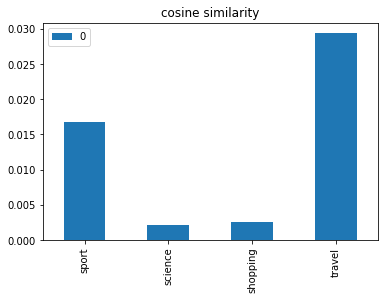

In [13]:
pd.DataFrame.from_dict(cosine_sims, orient='index').plot.bar(title='cosine similarity')

<AxesSubplot:title={'center':'jaccard similarity'}>

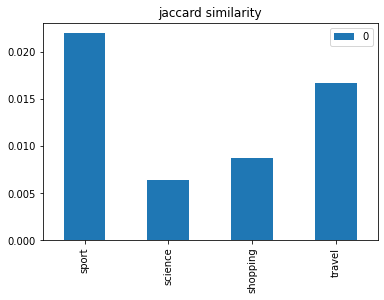

In [14]:
pd.DataFrame.from_dict(jaccard_sims, orient='index').plot.bar(title='jaccard similarity')